<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

In [440]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [12]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import warnings
import seaborn as sns
import plotly.express as px
from pylab import rcParams


## Загрузка данных

In [14]:
data = pd.read_csv('train.csv')

In [15]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',	
    'IsSeniorCitizen',
    'HasPartner',	
    'HasChild',	
    'HasPhoneService',	
    'HasMultiplePhoneNumbers',
    'HasInternetService',	
    'HasOnlineSecurityService',	
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',	
    'HasOnlineTV',	
    'HasMovieSubscription',	
    'HasContractPhone',	
    'IsBillingPaperless',	
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [16]:
# настройка отображений данных
pd.set_option('display.float_format','{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
rcParams['figure.figsize'] = 7, 7
warnings.filterwarnings('ignore')

In [17]:
display(data.head(2))

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0


In [18]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

None

Пропусков нет


In [19]:
# смотрю уникальные значения в каждой колонке
display(data.nunique())

ClientPeriod                  73
MonthlySpending             1468
TotalSpent                  4978
Sex                            2
IsSeniorCitizen                2
HasPartner                     2
HasChild                       2
HasPhoneService                2
HasMultiplePhoneNumbers        3
HasInternetService             3
HasOnlineSecurityService       3
HasOnlineBackup                3
HasDeviceProtection            3
HasTechSupportAccess           3
HasOnlineTV                    3
HasMovieSubscription           3
HasContractPhone               3
IsBillingPaperless             2
PaymentMethod                  4
Churn                          2
dtype: int64

In [20]:
display(data[num_cols].describe())

,ClientPeriod,MonthlySpending
count,5282.00,5282.00
mean,32.40,64.92
std,24.55,30.18
min,0.00,18.25
25%,9.00,35.46
50%,29.00,70.40
75%,55.00,90.05
max,72.00,118.75


In [21]:
# проверим есть ли дубликаты
data.duplicated().sum()

14

In [22]:
#удалим их
data = data.drop_duplicates()
data.duplicated().sum()

0

## Анализ данных

In [23]:
#меняю тип данных данныы
data.TotalSpent = pd.to_numeric(data.TotalSpent,errors = 'coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5268 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5259 non-null   float64
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 14  HasOnlin

In [24]:
#9 пропущенных заменяю на 0
data.TotalSpent = data.TotalSpent.fillna(value= 0)
data.TotalSpent.isna().value_counts()

False    5268
Name: TotalSpent, dtype: int64

пропусков нет

In [15]:
# проверим, есть ли в датасэте отрицательные значения
(data[num_cols].values < 0).any()

False

In [16]:
data_origin = data.copy()

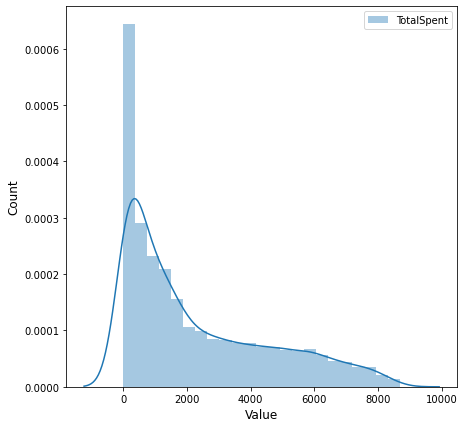

In [17]:
sns.distplot(data.TotalSpent, label= 'TotalSpent')
plt.ylabel("Count", fontsize=12)
plt.xlabel('Value', fontsize=12)
plt.legend()
plt.show()

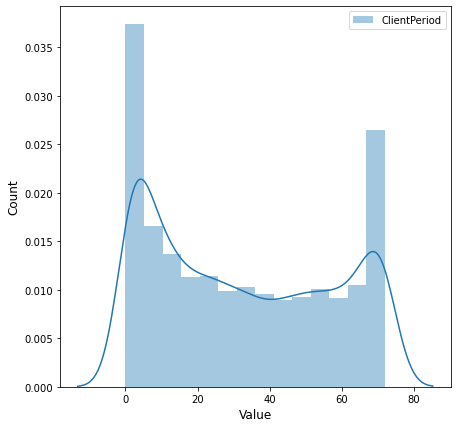

In [18]:
sns.distplot(data.ClientPeriod, label='ClientPeriod')
plt.ylabel("Count", fontsize=12)
plt.xlabel('Value', fontsize=12)
plt.legend()
plt.show()

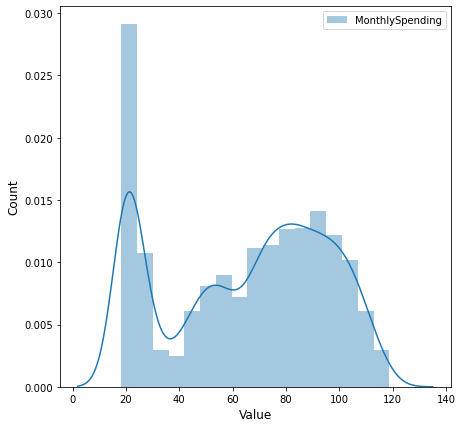

In [19]:
sns.distplot(data.MonthlySpending, label='MonthlySpending')
plt.ylabel("Count", fontsize=12)
plt.xlabel('Value', fontsize=12)
plt.legend()
plt.show()

In [20]:
def boxplot(columns, ylims):
    data.boxplot(column=columns) 
    plt.title(columns)
    plt.ylabel("Value", fontsize=15)
    plt.ylim(ylims)
    plt.show()

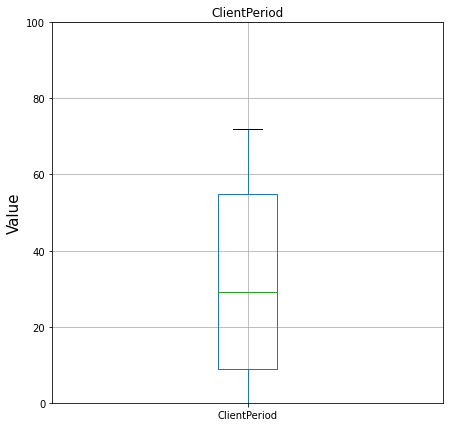

In [21]:
boxplot('ClientPeriod', (0, 100))

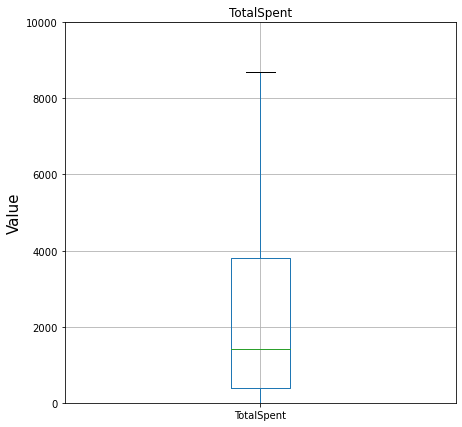

In [22]:
boxplot('TotalSpent', (0, 10000))

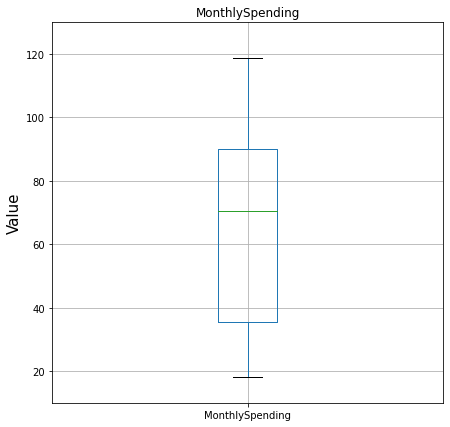

In [23]:
boxplot('MonthlySpending', (10, 130))

In [24]:
#функция, которая строит гистограмму в завистимости от целевого признака 
def hist(column, bins, title):
    plt.hist(data[data["Churn"]==1][column], color = 'red', alpha=0.5, 
         edgecolor="black",  bins = bins) 
    plt.hist(data[data["Churn"]==0][column], color = 'blue', alpha=0.5, 
         edgecolor="black", bins = bins)
    red_patch = mpatches.Patch(color='red', label='1')
    green_patch = mpatches.Patch(color='blue', label='0')
    plt.legend(handles=[red_patch, green_patch])
    plt.title(title, fontsize=16)
    plt.ylabel('Value', fontsize=15)
    plt.xlabel(column, fontsize=15)
    plt.show()

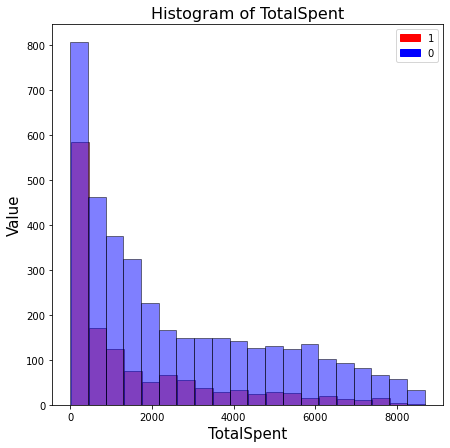

In [25]:
hist('TotalSpent', 20,'Histogram of TotalSpent',)

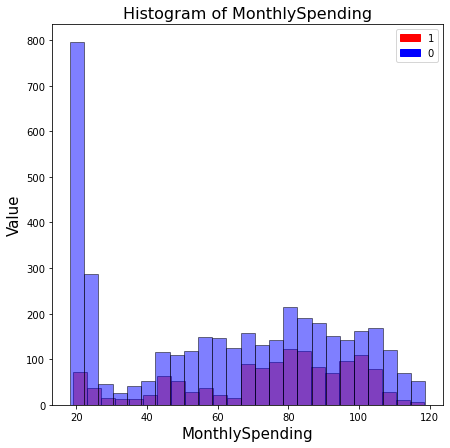

In [26]:
hist('MonthlySpending', 25,'Histogram of MonthlySpending',)

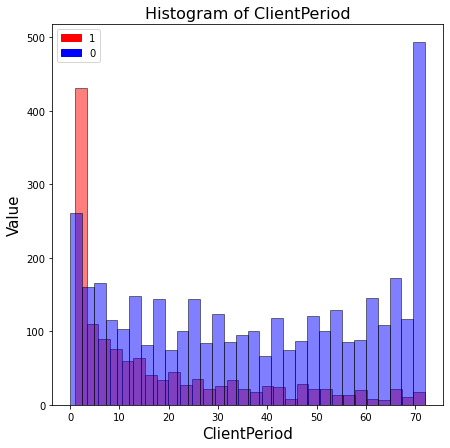

In [27]:
hist('ClientPeriod', 30,'Histogram of ClientPeriod',)

<AxesSubplot:>

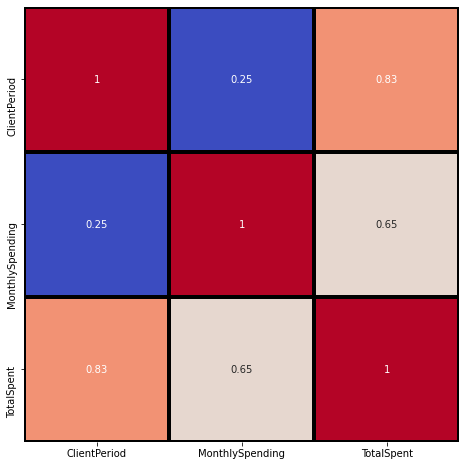

In [28]:
#Проверка на линейные зависимости числовый признаков
plt.subplots(figsize=(8,8))
sns.heatmap(data[num_cols].corr(), annot = True, cmap= 'coolwarm', linewidths=3,linecolor='black',square=True, cbar=False)

Удаляют обычно с корреляцией более 0,9, ничего не удаляю

In [29]:
data[cat_cols].head(5)

,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
3,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check
4,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic)


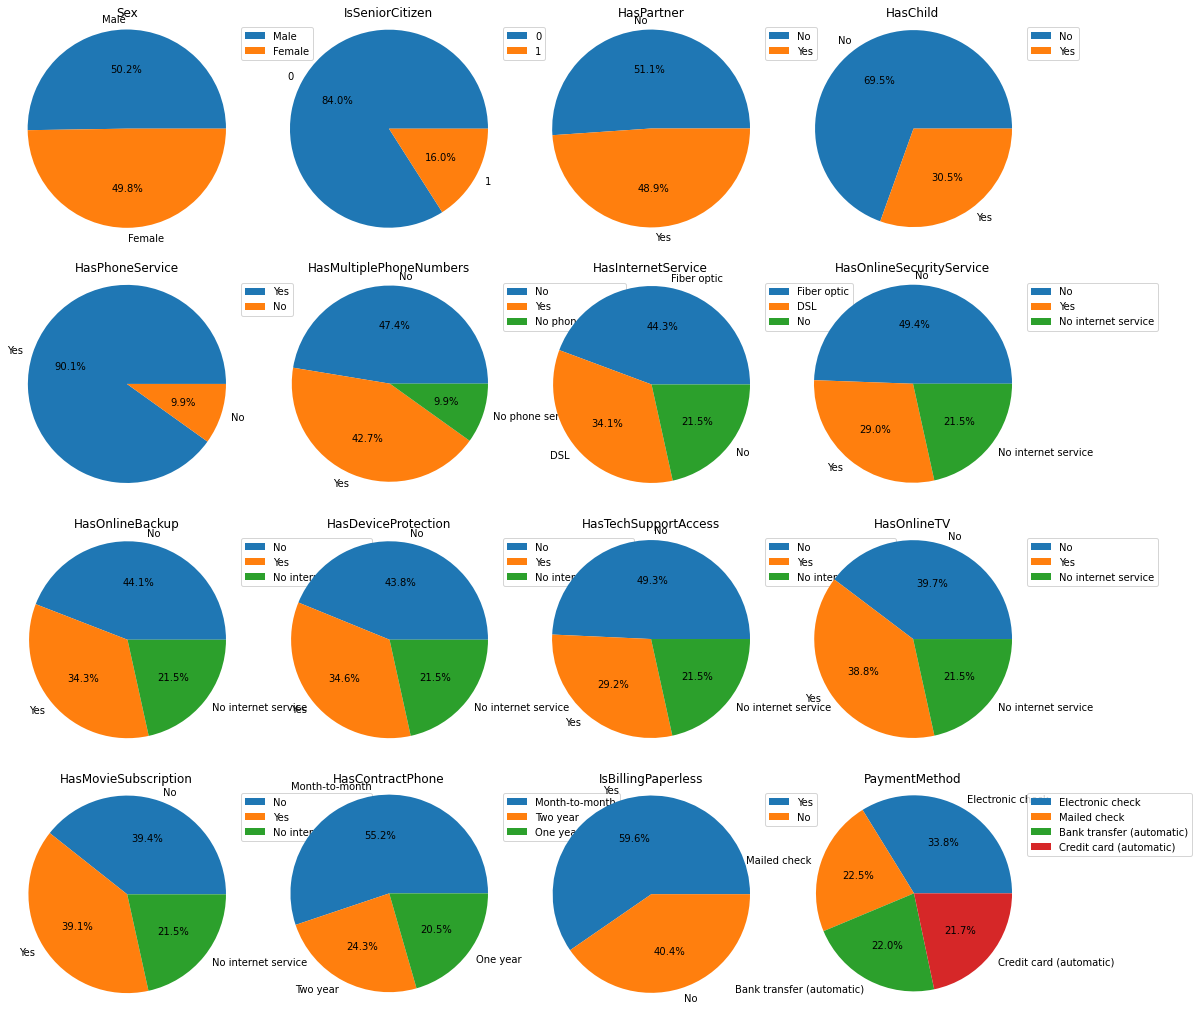

In [30]:
fig = plt.figure(figsize =(18, 18))
for column in range(len(cat_cols)):
    data_ = data[cat_cols[column]].value_counts()
    plt.subplot(4,4,column+1)
    plt.pie(data_, labels = data_.index, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(cat_cols[column])
    plt.legend(bbox_to_anchor=(1,1))


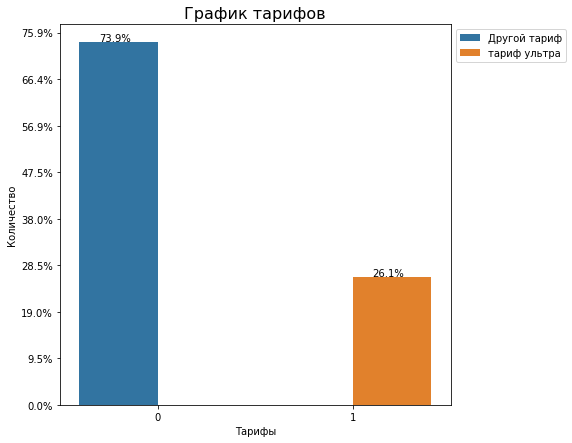

In [31]:
#Смотрим целевой признак
ax = sns.countplot(x = 'Churn', hue = 'Churn',
                   data = data)
ax.set_title('График тарифов',fontsize=16)
ax.set_xlabel('Тарифы', fontsize=10)
ax.set_ylabel('Количество', fontsize=10) 

legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Другой тариф','тариф ультра'], 
          bbox_to_anchor=(1,1))

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data['Churn'])), (p.get_x()+0.1, p.get_height()+10))

#по оси y можно поставить проценты        
_ = ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/len(data['Churn'])))


Наблюдается дисбаланс классов

## Применение линейных моделей

In [32]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

In [33]:
features = data[num_cols + cat_cols]
target = data[target_col]

In [34]:

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', OneHotEncoder(), cat_cols)])

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=42, class_weight=None, solver = 'liblinear', max_iter = 200))])

grid = {
    'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.linspace(0, 110, 50)
}

search = GridSearchCV(pipe, grid, cv=5, n_jobs=-1, scoring='roc_auc',refit=True)
grid_result = search.fit(features, target)

In [35]:
print('best params:', grid_result.best_params_)
print('best score:', grid_result.best_score_)
print('best_estimator:', grid_result.best_estimator_)

best params: {'classifier__C': 62.857142857142854, 'classifier__penalty': 'l1'}
best score: 0.8445906998983247
best_estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ClientPeriod',
                                                   'MonthlySpending',
                                                   'TotalSpent']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'IsSeniorCitizen',
                                                   'HasPartner', 'HasChild',
                                                   'HasPhoneService',
                                                   'HasMultiplePhoneNumbers',
                                      

Модель линейная регрессия со следующими параметрами 'C': 69.59183673469387, 'penalty': 'l1'}

## Применение градиентного бустинга

In [475]:
!pip install catboost

In [476]:
from catboost import CatBoostClassifier

In [477]:
feature  = data_origin.drop([target_col], axis = 1)
target = data_origin[target_col]
x_train, x_valid, y_train, y_valid = train_test_split(
    feature, target, test_size=0.2, random_state=12345)

In [478]:
#проверка размеров
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(4214, 19) (1054, 19) (4214,) (1054,)


In [487]:
#Настроиваем (вычисление среднего и дисперсии)
scaler = StandardScaler()
scaler.fit(features[num_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [488]:
#Преобразую обучающую, валидационную и тестовые выборки 
x_train[num_cols] = scaler.transform(x_train[num_cols])
x_valid[num_cols] = scaler.transform(x_valid[num_cols])

In [489]:
# обучение с дефолтными настройками
default = CatBoostClassifier(cat_features=cat_cols, random_seed=42, verbose=False)
default.fit(x_train, y_train)
roc_auc_score(y_valid, default.predict_proba(x_valid)[:, 1])

0.8394780288124477

In [496]:
#поиск по сетке
CBC = CatBoostClassifier(cat_features=cat_cols, 
                         random_state=42,
                         loss_function='Logloss',
                         learning_rate=0.1, verbose=50, eval_metric='AUC')
parameters = {
    'iterations': [50, 100, 150, 300],
    'min_data_in_leaf': [50, 75, 100],
    'depth': [6, 7],
    'l2_leaf_reg': [3, 5, 7]
}

Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, n_jobs=-1)
Grid_CBC.fit(x_train, y_train)


0:	total: 9.22ms	remaining: 913ms
50:	total: 294ms	remaining: 282ms
99:	total: 570ms	remaining: 0us


GridSearchCV(cv=None, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f963c021910>,
             iid='deprecated', n_jobs=-1,
             param_grid={'depth': [6, 7], 'iterations': [50, 100, 150, 300],
                         'l2_leaf_reg': [3, 5, 7],
                         'min_data_in_leaf': [50, 75, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

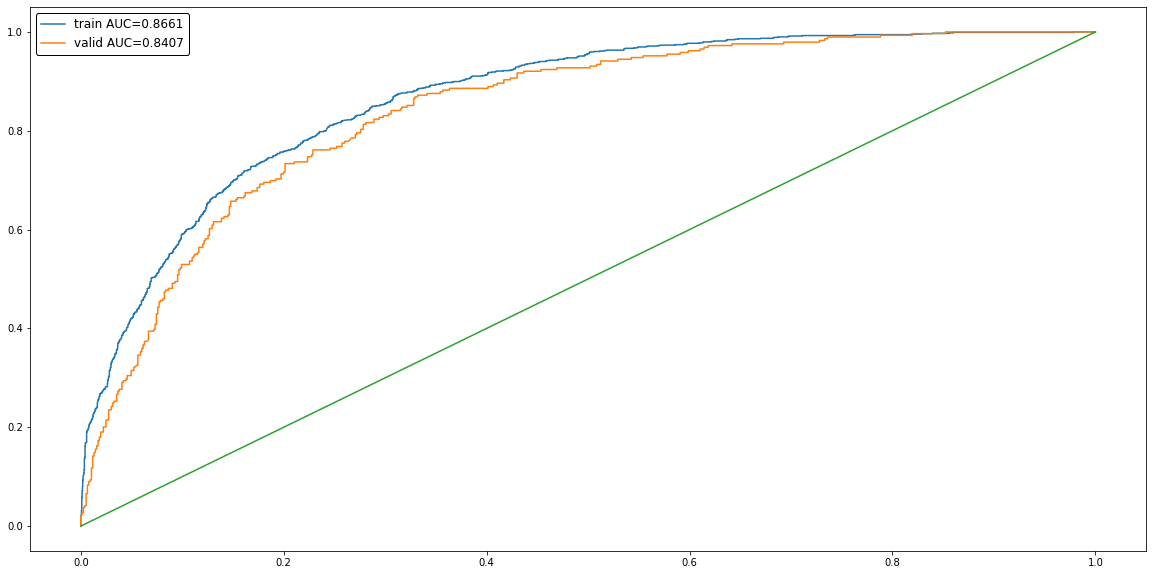

In [497]:
y_train_predicted = Grid_CBC.predict_proba(x_train)[:, 1]
y_valid_predicted = Grid_CBC.predict_proba(x_valid)[:, 1]


train_auc = roc_auc_score(y_train, y_train_predicted)
valid_auc = roc_auc_score(y_valid, y_valid_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_valid, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [504]:
print('best params:', Grid_CBC.best_params_)

best params: {'depth': 7, 'iterations': 100, 'l2_leaf_reg': 5, 'min_data_in_leaf': 50}


Лучшее качество на кагле 0,85, параметры 'depth': 7, 'iterations': 100, 'l2_leaf_reg': 5, 'min_data_in_leaf': 50}

# Предсказания

In [482]:
best_model = Grid_CBC

In [483]:
X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/МФТИ_DL/Продвинутый поток/4/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/МФТИ_DL/Продвинутый поток/4/submission.csv')

In [484]:
X_test.shape

(1761, 19)

In [502]:
submission['Churn'] = best_model.predict_proba(X_test) [:, 1] #best_model.predict_proba(X_test) / best_model.predict(X_test)
submission.to_csv('./my_submission.csv', index=False)